# Naive implementation of statevector simulation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
# Gate Definitions
X = np.array([[0, 1], [1, 0]])
H = np.array([[1, 1], [1, -1]]) / np.sqrt(2)
I = np.eye(2)
CNOT = np.array([[1, 0, 0, 0],
                 [0, 1, 0, 0],
                 [0, 0, 0, 1],
                 [0, 0, 1, 0]])

In [3]:
import pennylane as qml
#import pennylane.numpy as np

#### Quantum Circuit simulation using Pennylane

In [4]:
def apply_quantum(qubits):
    dev = qml.device("default.qubit", wires=qubits)

    @qml.qnode(dev)
    def circuit(qubits):
        for wire in range(qubits-1):
            qml.QubitUnitary(X, wires=wire)
            qml.QubitUnitary(H, wires=wire)
            qml.QubitUnitary(CNOT, wires=[wire,wire+1])
        qml.QubitUnitary(X, wires=qubits-1)
        qml.QubitUnitary(H, wires=qubits-1)
        return qml.state()
    
    state = circuit(qubits)
    return state

In [5]:
# Run Circuit with Matrix Multiplication
state1 = apply_quantum(4)
state1

tensor([ 0.25+0.j, -0.25+0.j, -0.25+0.j, -0.25+0.j, -0.25+0.j,  0.25+0.j,
        -0.25+0.j, -0.25+0.j, -0.25+0.j,  0.25+0.j,  0.25+0.j,  0.25+0.j,
        -0.25+0.j,  0.25+0.j, -0.25+0.j, -0.25+0.j], requires_grad=True)

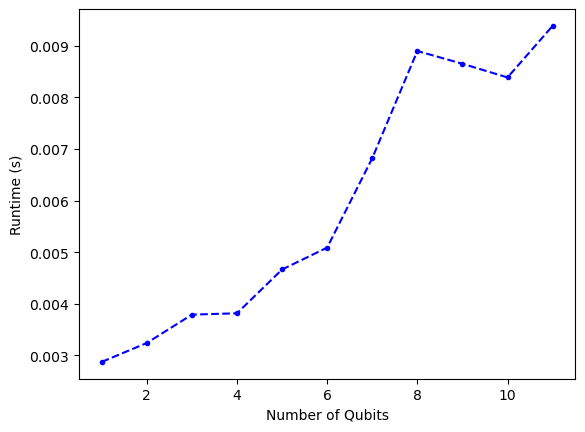

In [6]:
# Runtime Plot
qubits = range(1, 12)
times = []
states = []
for n in qubits:
    start = time.time()
    states.append(apply_quantum(n))
    times.append(time.time() - start)

plt.plot(qubits, times,marker = ".",ls = "--",c="b")
plt.xlabel('Number of Qubits')
plt.ylabel('Runtime (s)')
plt.show()

### Using only matrix multiplication

In [38]:
def direct_sum(a, b):
    m1, n1 = a.shape
    m2, n2 = b.shape
    c = np.zeros((m1 + m2, n1 + n2))
    
    c[:m1, :n1] = a   
    c[m1:, n1:] = b
    return c

In [39]:
# so we already have our operators, now we will calculate time required for computation.

def init_state(qubits):
    state = [1,0]
    for _ in range(qubits-1):
        state = np.kron(state,[1,0])
    return state

In [40]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer, AerSimulator
from qiskit.quantum_info import Operator

def cnot_op(qubits):
    c = QuantumCircuit(qubits)
    for i in range(qubits-1):
        c.cx(i+1,i)  
    #gate = c.to_gate()
    #matrix = c.to_matrix()
    matrix = Operator.from_circuit(c)
    return matrix.data

In [41]:
print(cnot_op(2))

[[1.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 1.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 1.+0.j]
 [0.+0.j 0.+0.j 1.+0.j 0.+0.j]]


In [42]:
def apply_numpy(qubits):
    initial = init_state(qubits)
    xop= 1
    hop= 1
    cnotop = cnot_op(qubits)
    for _ in range(qubits):
        xop = np.kron(xop,X)
        hop = np.kron(hop,H)
    
    state_vec = np.dot(xop,initial)
    state_vec = np.dot(hop,state_vec)
    state_vec = np.dot(cnotop,state_vec)
    
    return state_vec

In [43]:
# Run Circuit with Matrix Multiplication
state2 = apply_numpy(4)
state2

array([ 0.25+0.j, -0.25+0.j,  0.25+0.j, -0.25+0.j, -0.25+0.j,  0.25+0.j,
       -0.25+0.j,  0.25+0.j,  0.25+0.j, -0.25+0.j,  0.25+0.j, -0.25+0.j,
       -0.25+0.j,  0.25+0.j, -0.25+0.j,  0.25+0.j])

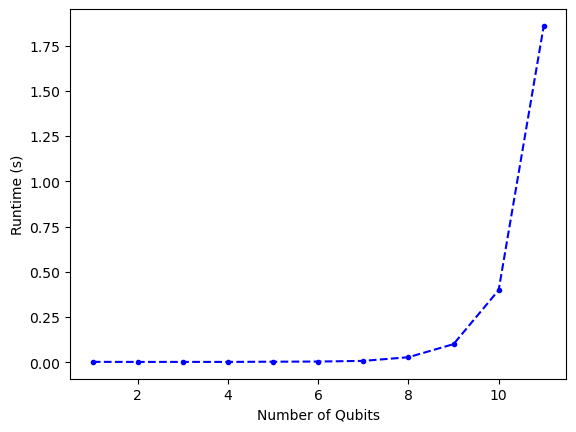

In [44]:
# Runtime Plot
qubits = range(1, 12)
times = []
states = []
for n in qubits:
    start = time.time()
    states.append(apply_numpy(n))
    times.append(time.time() - start)

plt.plot(qubits, times,marker = ".",ls = "--",c="b")
plt.xlabel('Number of Qubits')
plt.ylabel('Runtime (s)')
plt.show()

## Tensor method

In this case instead of using the numpy method we use the tensor method where ibstead of using a 1D vector we use tensor shapes. Therefore instead of representing $|00\rangle$ as `[1,0,0,0]`we instead represent it as `[[1,0],[1,0]]`.

In [45]:
def tensor_apply(state, gate, target, n):
    axes = [target] + list(range(target)) + list(range(target + 1, n))
    gate_expanded = np.tensordot(gate, state, axes=(1, target))
    return np.reshape(gate_expanded, state.shape)

In [46]:
def run_tensor_circuit(n):
    state = np.zeros((2,) * n)
    state[(0,) * n] = 1
    state = tensor_apply(state, X, 0, n)
    state = tensor_apply(state, H, 0, n)
    #if n > 1:
    #   state = tensor_apply(state, CNOT, 0, n)
    return state

In [47]:
qubits = range(1, 12)
times_tensor = []
states_tensor = []
for n in qubits:
    start = time.time()
    states_tensor.append(run_tensor_circuit(n))    
    times_tensor.append(time.time() - start)

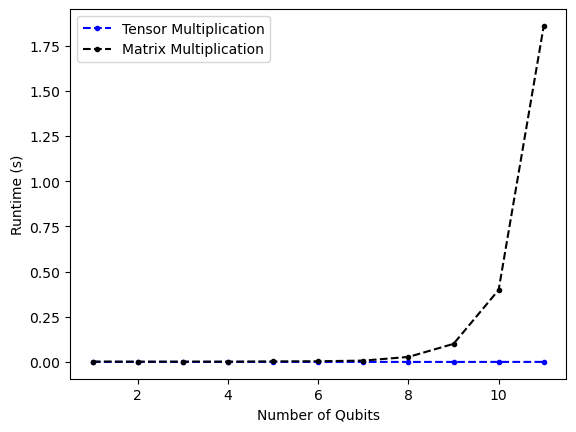

In [53]:
plt.plot(qubits, times_tensor, label="Tensor Multiplication",marker = ".",ls = "--",c="b")
plt.plot(qubits, times, label="Matrix Multiplication",marker = ".",ls = "--",c="black")
plt.xlabel('Number of Qubits')
plt.ylabel('Runtime (s)')
plt.legend()
plt.show()

In [27]:
states_tensor[3]

array([[[[ 0.70710678,  0.        ],
         [ 0.        ,  0.        ]],

        [[ 0.        ,  0.        ],
         [ 0.        ,  0.        ]]],


       [[[-0.70710678,  0.        ],
         [ 0.        ,  0.        ]],

        [[ 0.        ,  0.        ],
         [ 0.        ,  0.        ]]]])

In [33]:
def init_tensor(qubits):
    init = np.reshape([1,0]*qubits, [qubits,2])
    return init

def tensormethod(qubits):
    
    state = init_tensor(qubits)
    
    for i in range(qubits-1):
        state = np.dot(X,np.reshape(state[i:i+1],[2,1]))#,axes=1)
        state = np.dot(H,np.reshape(state[i:i+1],[2,1]))#,axes=1)
        #if state[i:i+1][1] != 0
        #    state = np.tensordot(CNOT, np.flatten(state[i:i+2]), axes=1) # HERE we have a problem
    #state = np.tensordot(x_t, state, axes=1)
    #state = np.tensordot(h_t, state, axes=1)
    
    return state

In [34]:
state = init_tensor(3)
#print(state[1:3])
print(state[1:2])
#print(state[2:3])

[[1 0]]


In [35]:
np.dot(X,np.reshape(state[1:2],[2,1]))#,axes=1)

array([[0],
       [1]])

In [36]:
tensormethod(3)

ValueError: cannot reshape array of size 1 into shape (2,1)

The problem with CNOT and axes and tensor representation

In [37]:
np.dot(CNOT,np.ndarray.flatten(state[1:3])).reshape(2,2)#,axes=1)

array([[1, 0],
       [0, 1]])